In [75]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
from dotmap import DotMap
import pandas as pd
from tqdm.notebook import tqdm
import json
import re

%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'font.size': 15})

# https://www.kaggle.com/datasets/ruchi798/star-wars

In [2]:
credits = pd.read_csv('data/kaggle/credits.csv')

# Drop the crew column
credits = credits.drop('crew', axis=1)

credits.cast = credits.cast.apply(eval)

In [3]:
movies = pd.read_csv('data/kaggle/movies_metadata.csv')

# Remove duplicate rows
movies = movies.drop_duplicates(subset='id')
movies = movies.drop_duplicates(subset='imdb_id')

# Cleanup
movies = movies[movies.imdb_id != '0']
movies = movies[movies.imdb_id.notna()]
movies = movies[movies.release_date.notna()]

# Convert id to int
movies.id = movies.id.astype(int)

/var/folders/l_/vnq08k4n0hn498fyp2mcvcsm0000gn/T/ipykernel_8227/912977457.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv('data/kaggle/movies_metadata.csv')


In [4]:
episode_to_titleId = ['tt0120915', 'tt0121765', 'tt0121766', 'tt0076759', 'tt0080684', 'tt0086190', 'tt2488496']

episode_dates = [movies[movies['imdb_id'] == id]['release_date'].values[0] for id in episode_to_titleId]

['1999-05-19',
 '2002-05-15',
 '2005-05-17',
 '1977-05-25',
 '1980-05-17',
 '1983-05-23',
 '2015-12-15']

In [5]:
from itertools import combinations

credits_movie = pd.merge(credits, movies, on='id', how='inner')

credits_movie.to_pickle('data/kaggle/credits_movie.pkl')

In [6]:
G = nx.Graph()

for i, row in tqdm(credits_movie.iterrows(), total=len(credits_movie)):
    for actor1, actor2 in combinations(row.cast, 2):
        key_1 = actor1['id'], actor1['name']
        key_2 = actor2['id'], actor2['name']
        date = row.release_date
        for key in [key_1, key_2]:
            if key in G:
                G.nodes[key]['date'] = min(G.nodes[key]['date'], date)
            else:
                G.add_node(key, date=date)
        if G.has_edge(key_1, key_2):
            G.edges[key_1, key_2]['date'] = min(G.edges[key_1, key_2]['date'], date)
        else:
            G.add_edge(key_1, key_2, date=date)

G = nx.subgraph(G, max(nx.connected_components(G), key=len))

  0%|          | 0/45375 [00:00<?, ?it/s]

In [7]:
episode_networks = []
order = sorted(enumerate(episode_dates), reverse=True, key=lambda x: x[1])
for i, (_, date) in tqdm(enumerate(order), total=len(episode_dates)):
    if i == 0:
        episode_network = nx.subgraph(G, [n for n in G.nodes if G.nodes[n]['date'] <= date]).copy()
    else:
        prev = episode_networks[i-1]
        episode_network = nx.subgraph(prev, [n for n in prev.nodes if prev.nodes[n]['date'] <= date]).copy()
    for edge in episode_network.edges:
        if episode_network.edges[edge]['date'] >= date:
            episode_network.remove_edge(*edge)
    episode_network = nx.subgraph(episode_network, max(nx.connected_components(episode_network), key=len))
    episode_networks.append(episode_network)


episode_networks = [n for _, n in sorted(zip(order, episode_networks), key=lambda x: x[0][0])]

  0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
for i, n in enumerate(episode_networks):
    nx.write_gpickle(n, f'data/kaggle/nets/ep_{i+1}.gpickle')

In [11]:
nx.write_gpickle(G, 'data/kaggle/nets/full.gpickle')

In [85]:
print('num_nodes', len(G))
print('num_edges', len(G.edges))
print('avg_degree', np.mean([d for n, d in tqdm(G.degree(), total=len(G))]))
print('max_degree', max([d for n, d in tqdm(G.degree(), total=len(G))]))
print('avg_clustering', nx.average_clustering(G))
print('diameter', nx.diameter(G))

num_nodes 199290
num_edges 6161641


  0%|          | 0/199290 [00:00<?, ?it/s]

avg_degree 61.83592754277686


  0%|          | 0/199290 [00:00<?, ?it/s]

max_degree 3371
avg_clustering 0.7882372281678935


KeyboardInterrupt: 

In [25]:
degree_df = np.unique(sorted([d for _, d in tqdm(G.degree(), total=len(G))]), return_counts=True)
sum_deg = np.sum(degree_df[1])

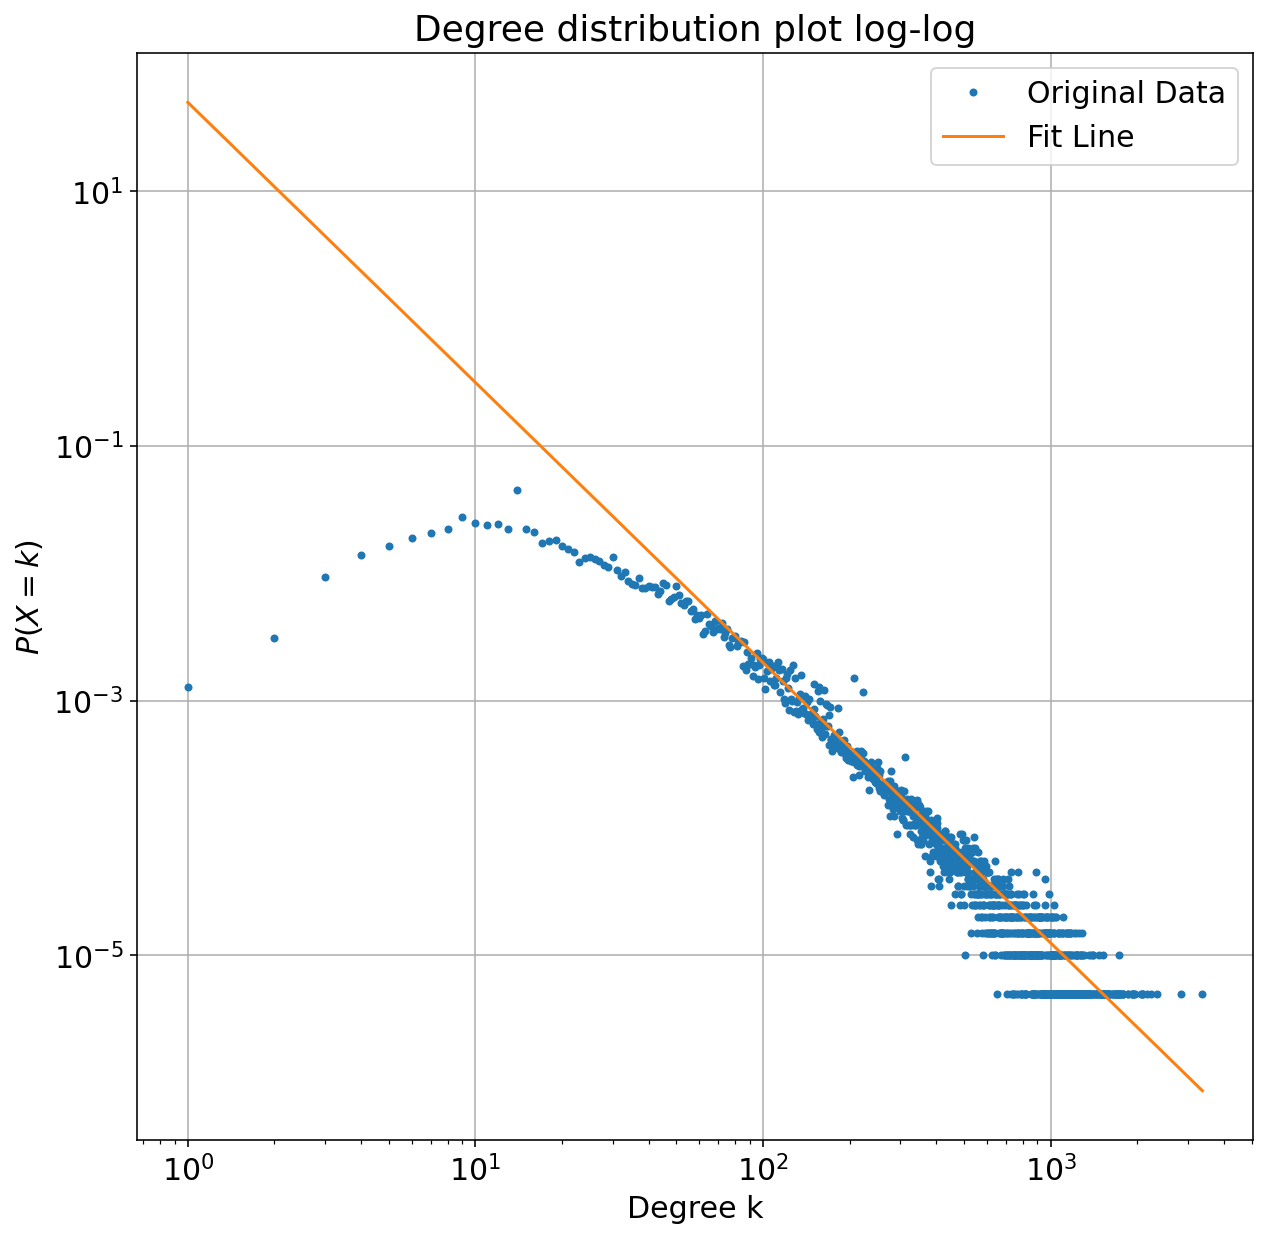

In [84]:
plt.figure(figsize=(10, 10))
plt.loglog(degree_df[0], degree_df[1] / sum_deg, '.', label='Original Data')
plt.loglog(degree_df[0], 5e1 / degree_df[0]**2.2, label='Fit Line')
plt.xlabel('Degree k')
plt.ylabel('$P(X=k)$')
# plt.title('Degree distribution plot log-log')
plt.legend()
plt.grid()